# Trading Analysis - Aggregated Orders

This notebook analyzes trading performance from `aggregated_orders.csv` with a focus on:
1. **Hourly Win Rate**: Winning percentage for each hour of the day
2. **Win Rate by Contract Size**: Winning percentage for each distinct contract count

We exclude cancelled orders from these calculations.

In [252]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Load and Prepare Data

In [253]:
# Load the CSV file
df = pd.read_csv('aggregated_orders.csv')

# Convert Timestamp_ET to datetime
df['Timestamp_ET'] = pd.to_datetime(df['Timestamp_ET'])

# Extract hour from timestamp
df['Hour'] = df['Timestamp_ET'].dt.hour

# Display basic info
print(f"Total orders: {len(df)}")
print(f"\nStatus distribution:")
print(df['Status'].value_counts())
print(f"\nFirst few rows:")
df.head()

Total orders: 2417

Status distribution:
Status
Loss         955
Profit       870
Cancelled    591
Filled         1
Name: count, dtype: int64

First few rows:


,Timestamp,Timestamp_ET,Order_Type,Entry_Type,Status,Low,High,Entry_Point,Stop_Loss,Take_Profit,...,At_Risk,Potential,Placed_Timestamp,Placed_Timestamp_ET,Filled_Timestamp,Filled_Timestamp_ET,Close_Timestamp,Close_Timestamp_ET,Cancel_Reason,Hour
0,1728466620000,2024-10-09 09:37:00,Long,EngulfingOrderBlock,Profit,5794.00,5797.25,5797.25,5794.00,5803.75,...,536.25,1072.5,1.728467e+12,2024-10-09 09:38:00,1.728467e+12,2024-10-09 09:38:00,1.728467e+12,2024-10-09 09:40:00,NaN,9
1,1728475560000,2024-10-09 12:06:00,Long,EngulfingOrderBlock,Loss,5831.75,5834.50,5834.50,5831.75,5840.00,...,550.00,1100.0,1.728476e+12,2024-10-09 12:07:00,1.728476e+12,2024-10-09 12:08:00,1.728476e+12,2024-10-09 12:15:00,NaN,12
2,1728482220000,2024-10-09 13:57:00,Long,EngulfingOrderBlock,Cancelled,5826.00,5828.00,5828.00,5826.00,5832.00,...,550.00,1100.0,NaN,NaN,NaN,NaN,1.728483e+12,2024-10-09 14:02:00,More than ten minutes have passed and the cand...,13
3,1728482940000,2024-10-09 14:09:00,Short,EngulfingOrderBlock,Cancelled,5829.75,5831.75,5829.75,5831.75,5825.75,...,550.00,1100.0,1.728483e+12,2024-10-09 14:10:00,NaN,NaN,1.728484e+12,2024-10-09 14:19:00,More than ten minutes have passed and the cand...,14
4,1728485940000,2024-10-09 14:59:00,Long,EngulfingOrderBlock,Loss,5829.75,5831.25,5831.25,5829.75,5834.25,...,547.50,1095.0,1.728486e+12,2024-10-09 15:05:00,1.728486e+12,2024-10-09 15:05:00,1.728486e+12,2024-10-09 15:07:00,NaN,14


In [254]:
# Filter out cancelled orders for win rate calculations
df_executed = df[df['Status'].isin(['Profit', 'Loss'])].copy()

print(f"Executed orders (excluding cancelled): {len(df_executed)}")
print(f"Profit orders: {len(df_executed[df_executed['Status'] == 'Profit'])}")
print(f"Loss orders: {len(df_executed[df_executed['Status'] == 'Loss'])}")
print(f"\nOverall win rate: {(df_executed['Status'] == 'Profit').sum() / len(df_executed) * 100:.2f}%")

Executed orders (excluding cancelled): 1825
Profit orders: 870
Loss orders: 955

Overall win rate: 47.67%


## 1. Win Rate by Hour of Day

In [255]:
# Calculate win rate by hour
hourly_stats = df_executed.groupby('Hour').agg({
    'Status': [
        ('Total_Trades', 'count'),
        ('Wins', lambda x: (x == 'Profit').sum()),
        ('Losses', lambda x: (x == 'Loss').sum())
    ]
}).reset_index()

# Flatten column names
hourly_stats.columns = ['Hour', 'Total_Trades', 'Wins', 'Losses']

# Calculate win percentage
hourly_stats['Win_Rate'] = (hourly_stats['Wins'] / hourly_stats['Total_Trades'] * 100).round(2)

# Display the results
print("Win Rate by Hour of Day:")
print("="*60)
hourly_stats

Win Rate by Hour of Day:


,Hour,Total_Trades,Wins,Losses,Win_Rate
0,9,161,76,85,47.20
1,10,299,136,163,45.48
2,11,272,137,135,50.37
3,12,261,119,142,45.59
4,13,270,125,145,46.30
5,14,285,123,162,43.16
6,15,277,154,123,55.60


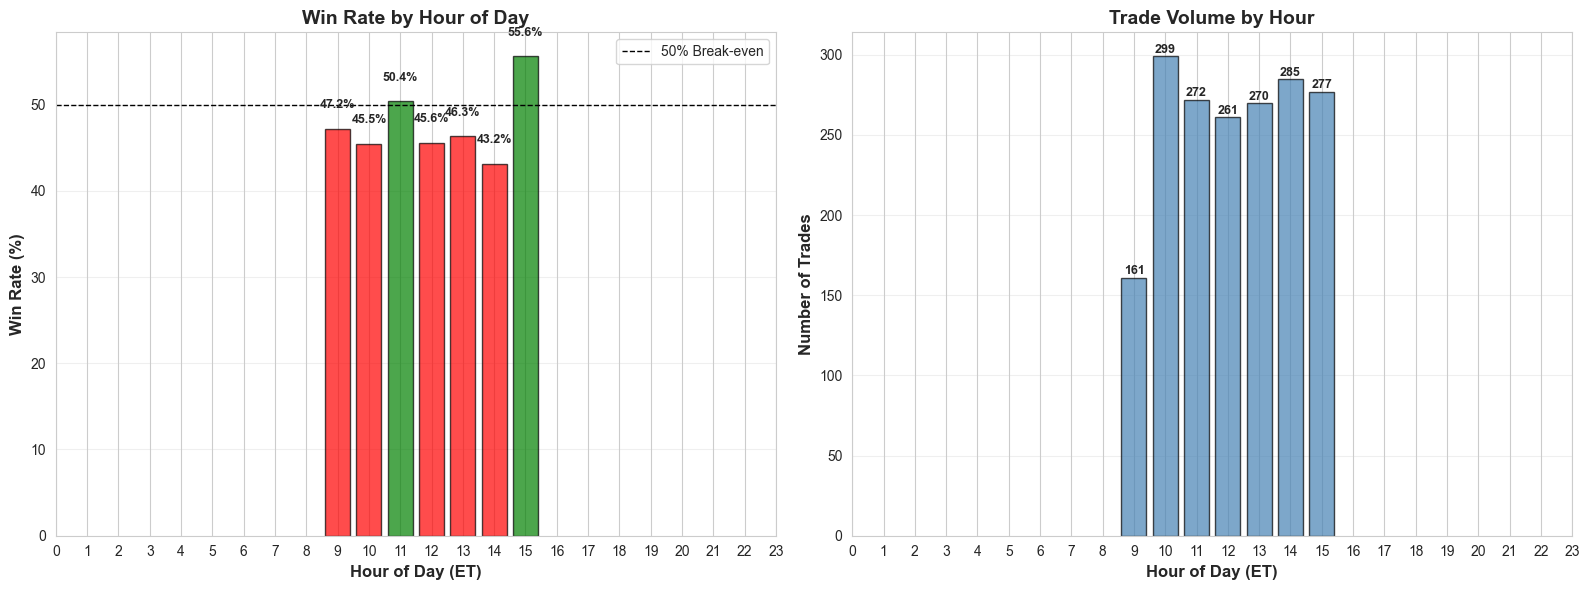

In [256]:
# Visualize hourly win rates
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of win rate by hour
colors = ['green' if x >= 50 else 'red' for x in hourly_stats['Win_Rate']]
ax1.bar(hourly_stats['Hour'], hourly_stats['Win_Rate'], color=colors, alpha=0.7, edgecolor='black')
ax1.axhline(y=50, color='black', linestyle='--', linewidth=1, label='50% Break-even')
ax1.set_xlabel('Hour of Day (ET)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Win Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Win Rate by Hour of Day', fontsize=14, fontweight='bold')
ax1.set_xticks(range(24))
ax1.grid(axis='y', alpha=0.3)
ax1.legend()

# Add value labels on bars
for i, (hour, rate) in enumerate(zip(hourly_stats['Hour'], hourly_stats['Win_Rate'])):
    ax1.text(hour, rate + 2, f'{rate:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Bar chart of trade volume by hour
ax2.bar(hourly_stats['Hour'], hourly_stats['Total_Trades'], color='steelblue', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Hour of Day (ET)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Trades', fontsize=12, fontweight='bold')
ax2.set_title('Trade Volume by Hour', fontsize=14, fontweight='bold')
ax2.set_xticks(range(24))
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (hour, count) in enumerate(zip(hourly_stats['Hour'], hourly_stats['Total_Trades'])):
    ax2.text(hour, count + 0.1, str(count), ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## 2. Win Rate by Contract Size

In [257]:
# Calculate win rate by contract size
contract_stats = df_executed.groupby('Contracts').agg({
    'Status': [
        ('Total_Trades', 'count'),
        ('Wins', lambda x: (x == 'Profit').sum()),
        ('Losses', lambda x: (x == 'Loss').sum())
    ]
}).reset_index()

# Flatten column names
contract_stats.columns = ['Contracts', 'Total_Trades', 'Wins', 'Losses']

# Calculate win percentage
contract_stats['Win_Rate'] = (contract_stats['Wins'] / contract_stats['Total_Trades'] * 100).round(2)

# Sort by contract size
contract_stats = contract_stats.sort_values('Contracts')

# Display the results
print("Win Rate by Contract Size:")
print("="*60)
contract_stats

Win Rate by Contract Size:


,Contracts,Total_Trades,Wins,Losses,Win_Rate
0,3,1,0,1,0.00
1,4,4,2,2,50.00
2,5,3,0,3,0.00
3,6,2,2,0,100.00
4,7,10,4,6,40.00
5,8,9,4,5,44.44
6,9,8,6,2,75.00
7,10,4,3,1,75.00
8,11,13,8,5,61.54
9,12,13,8,5,61.54


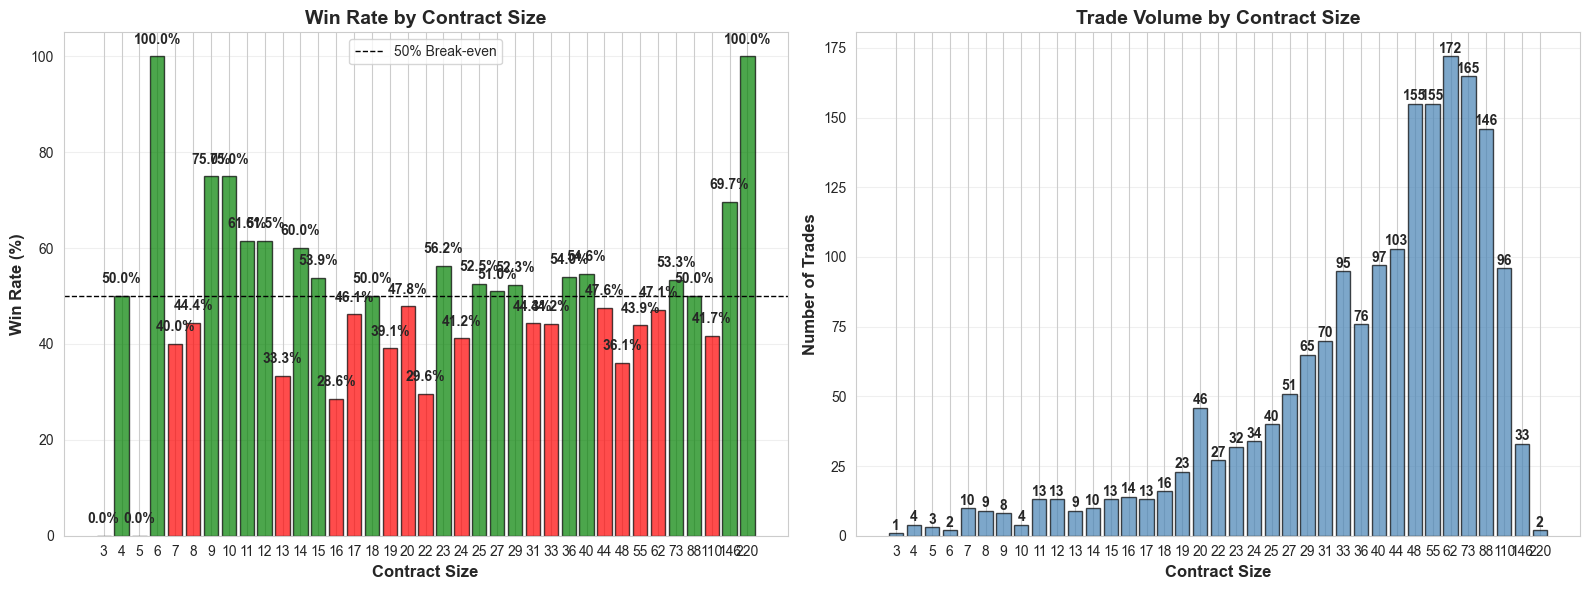

In [258]:
# Visualize win rates by contract size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of win rate by contract size
colors = ['green' if x >= 50 else 'red' for x in contract_stats['Win_Rate']]
ax1.bar(contract_stats['Contracts'].astype(str), contract_stats['Win_Rate'], color=colors, alpha=0.7, edgecolor='black')
ax1.axhline(y=50, color='black', linestyle='--', linewidth=1, label='50% Break-even')
ax1.set_xlabel('Contract Size', fontsize=12, fontweight='bold')
ax1.set_ylabel('Win Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Win Rate by Contract Size', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.legend()

# Add value labels on bars
for i, (contracts, rate) in enumerate(zip(contract_stats['Contracts'], contract_stats['Win_Rate'])):
    ax1.text(i, rate + 2, f'{rate:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Bar chart of trade volume by contract size
ax2.bar(contract_stats['Contracts'].astype(str), contract_stats['Total_Trades'], color='steelblue', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Contract Size', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Trades', fontsize=12, fontweight='bold')
ax2.set_title('Trade Volume by Contract Size', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (contracts, count) in enumerate(zip(contract_stats['Contracts'], contract_stats['Total_Trades'])):
    ax2.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Summary

In [259]:
# Find best and worst performing hours
best_hour = hourly_stats.loc[hourly_stats['Win_Rate'].idxmax()]
worst_hour = hourly_stats.loc[hourly_stats['Win_Rate'].idxmin()]

print("="*60)
print("HOURLY PERFORMANCE SUMMARY")
print("="*60)
print(f"\nBest Hour: {int(best_hour['Hour'])}:00")
print(f"  Win Rate: {best_hour['Win_Rate']:.2f}%")
print(f"  Total Trades: {int(best_hour['Total_Trades'])}")
print(f"  Wins: {int(best_hour['Wins'])}, Losses: {int(best_hour['Losses'])}")

print(f"\nWorst Hour: {int(worst_hour['Hour'])}:00")
print(f"  Win Rate: {worst_hour['Win_Rate']:.2f}%")
print(f"  Total Trades: {int(worst_hour['Total_Trades'])}")
print(f"  Wins: {int(worst_hour['Wins'])}, Losses: {int(worst_hour['Losses'])}")

# Find best and worst performing contract sizes
best_contracts = contract_stats.loc[contract_stats['Win_Rate'].idxmax()]
worst_contracts = contract_stats.loc[contract_stats['Win_Rate'].idxmin()]

print("\n" + "="*60)
print("CONTRACT SIZE PERFORMANCE SUMMARY")
print("="*60)
print(f"\nBest Contract Size: {int(best_contracts['Contracts'])}")
print(f"  Win Rate: {best_contracts['Win_Rate']:.2f}%")
print(f"  Total Trades: {int(best_contracts['Total_Trades'])}")
print(f"  Wins: {int(best_contracts['Wins'])}, Losses: {int(best_contracts['Losses'])}")

print(f"\nWorst Contract Size: {int(worst_contracts['Contracts'])}")
print(f"  Win Rate: {worst_contracts['Win_Rate']:.2f}%")
print(f"  Total Trades: {int(worst_contracts['Total_Trades'])}")
print(f"  Wins: {int(worst_contracts['Wins'])}, Losses: {int(worst_contracts['Losses'])}")
print("="*60)

HOURLY PERFORMANCE SUMMARY

Best Hour: 15:00
  Win Rate: 55.60%
  Total Trades: 277
  Wins: 154, Losses: 123

Worst Hour: 14:00
  Win Rate: 43.16%
  Total Trades: 285
  Wins: 123, Losses: 162

CONTRACT SIZE PERFORMANCE SUMMARY

Best Contract Size: 6
  Win Rate: 100.00%
  Total Trades: 2
  Wins: 2, Losses: 0

Worst Contract Size: 3
  Win Rate: 0.00%
  Total Trades: 1
  Wins: 0, Losses: 1


## 3. Win Rate by Order Type (Long vs Short)

Win Rate by Order Type:
Order_Type  Total_Trades  Wins  Losses  Win_Rate
      Long           922   414     508      44.9
     Short           903   456     447      50.5


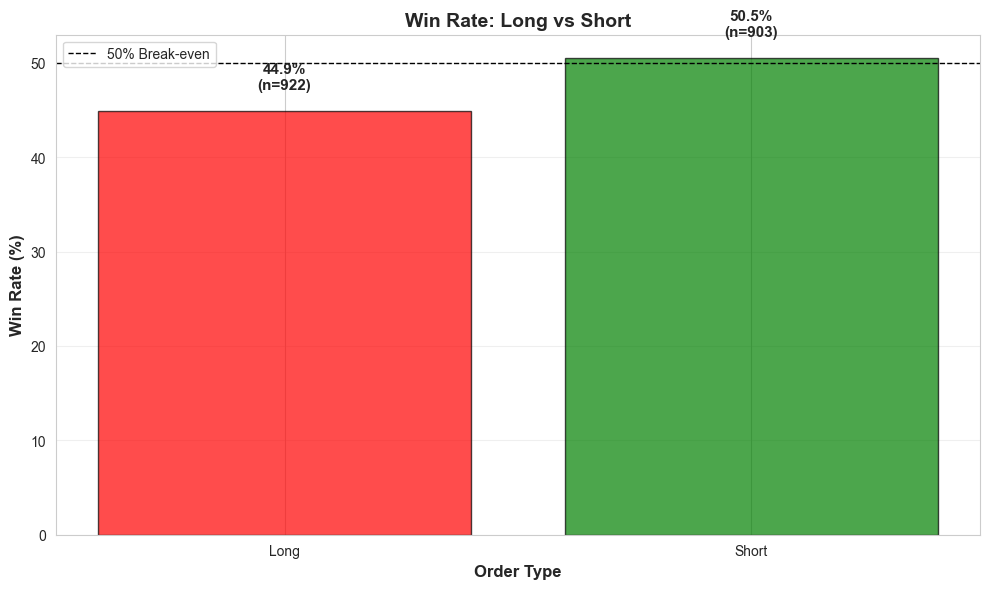

In [260]:
# Calculate win rate by order type
order_type_stats = df_executed.groupby('Order_Type').agg({
    'Status': [
        ('Total_Trades', 'count'),
        ('Wins', lambda x: (x == 'Profit').sum()),
        ('Losses', lambda x: (x == 'Loss').sum())
    ]
}).reset_index()

order_type_stats.columns = ['Order_Type', 'Total_Trades', 'Wins', 'Losses']
order_type_stats['Win_Rate'] = (order_type_stats['Wins'] / order_type_stats['Total_Trades'] * 100).round(2)

print("Win Rate by Order Type:")
print("="*60)
print(order_type_stats.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
colors_order = ['green' if x >= 50 else 'red' for x in order_type_stats['Win_Rate']]
bars = ax.bar(order_type_stats['Order_Type'], order_type_stats['Win_Rate'], 
               color=colors_order, alpha=0.7, edgecolor='black')
ax.axhline(y=50, color='black', linestyle='--', linewidth=1, label='50% Break-even')
ax.set_xlabel('Order Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Win Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Win Rate: Long vs Short', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.legend()

for i, (order_type, rate, count) in enumerate(zip(order_type_stats['Order_Type'], 
                                                    order_type_stats['Win_Rate'],
                                                    order_type_stats['Total_Trades'])):
    ax.text(i, rate + 2, f'{rate:.1f}%\n(n={count})', ha='center', va='bottom', 
            fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Win Rate by Day of Week

Win Rate by Day of Week:
DayOfWeek  Total_Trades  Wins  Losses  Win_Rate
   Monday           352   159     193     45.17
  Tuesday           406   200     206     49.26
Wednesday           368   183     185     49.73
 Thursday           357   166     191     46.50
   Friday           342   162     180     47.37


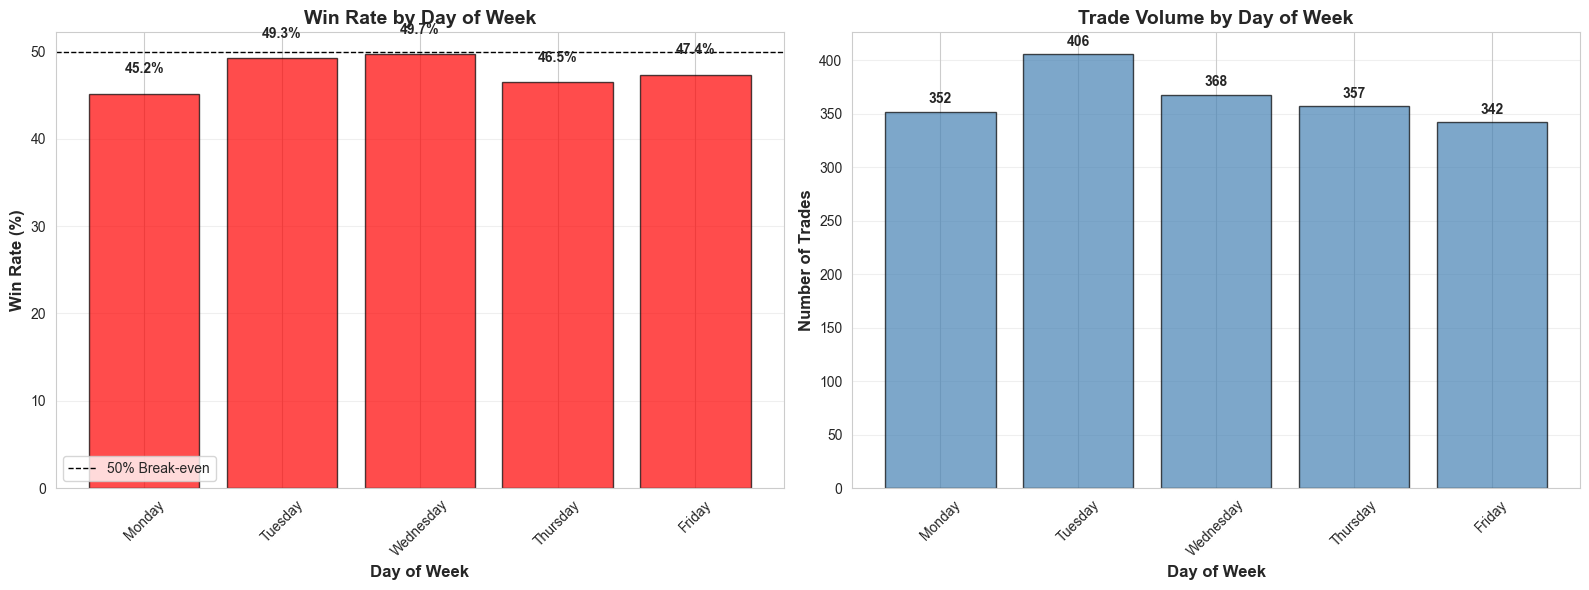

In [261]:
# Add day of week to executed trades
df_executed['DayOfWeek'] = df_executed['Timestamp_ET'].dt.day_name()
df_executed['DayNum'] = df_executed['Timestamp_ET'].dt.dayofweek

# Calculate win rate by day
day_stats = df_executed.groupby(['DayNum', 'DayOfWeek']).agg({
    'Status': [
        ('Total_Trades', 'count'),
        ('Wins', lambda x: (x == 'Profit').sum()),
        ('Losses', lambda x: (x == 'Loss').sum())
    ]
}).reset_index()

day_stats.columns = ['DayNum', 'DayOfWeek', 'Total_Trades', 'Wins', 'Losses']
day_stats['Win_Rate'] = (day_stats['Wins'] / day_stats['Total_Trades'] * 100).round(2)
day_stats = day_stats.sort_values('DayNum')

print("Win Rate by Day of Week:")
print("="*60)
print(day_stats[['DayOfWeek', 'Total_Trades', 'Wins', 'Losses', 'Win_Rate']].to_string(index=False))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Win rate by day
colors_day = ['green' if x >= 50 else 'red' for x in day_stats['Win_Rate']]
ax1.bar(day_stats['DayOfWeek'], day_stats['Win_Rate'], color=colors_day, alpha=0.7, edgecolor='black')
ax1.axhline(y=50, color='black', linestyle='--', linewidth=1, label='50% Break-even')
ax1.set_xlabel('Day of Week', fontsize=12, fontweight='bold')
ax1.set_ylabel('Win Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Win Rate by Day of Week', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)
ax1.legend()

for i, (day, rate) in enumerate(zip(day_stats['DayOfWeek'], day_stats['Win_Rate'])):
    ax1.text(i, rate + 2, f'{rate:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Trade volume by day
ax2.bar(day_stats['DayOfWeek'], day_stats['Total_Trades'], color='steelblue', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Day of Week', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Trades', fontsize=12, fontweight='bold')
ax2.set_title('Trade Volume by Day of Week', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

for i, (day, count) in enumerate(zip(day_stats['DayOfWeek'], day_stats['Total_Trades'])):
    ax2.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Combined Analysis: Order Type by Hour

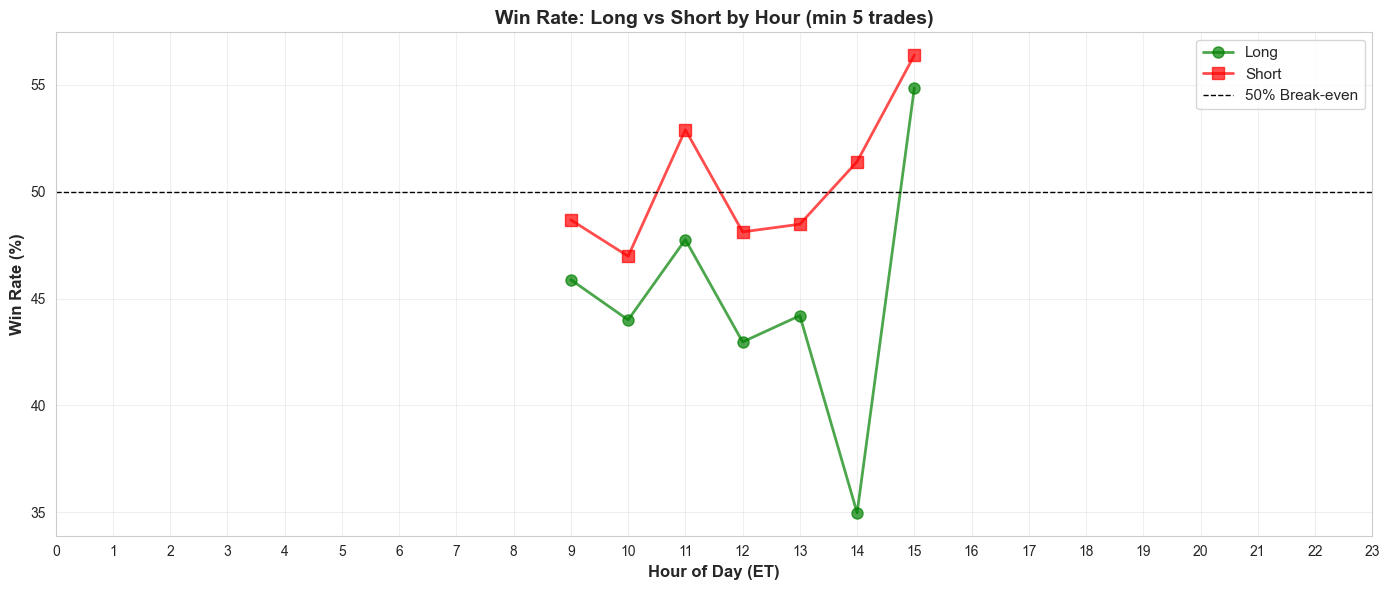


Hours where Long significantly outperforms Short (>20% difference):
None found

Hours where Short significantly outperforms Long (>20% difference):
None found


In [262]:
# Maybe certain order types perform better at certain hours?
combined_stats = df_executed.groupby(['Hour', 'Order_Type']).agg({
    'Status': [
        ('Total_Trades', 'count'),
        ('Wins', lambda x: (x == 'Profit').sum())
    ]
}).reset_index()

combined_stats.columns = ['Hour', 'Order_Type', 'Total_Trades', 'Wins']
combined_stats['Win_Rate'] = (combined_stats['Wins'] / combined_stats['Total_Trades'] * 100).round(2)

# Only show hours with at least 5 trades for each type
filtered_combined = combined_stats[combined_stats['Total_Trades'] >= 5].copy()

if len(filtered_combined) > 0:
    # Pivot for better visualization
    pivot_data = filtered_combined.pivot(index='Hour', columns='Order_Type', values='Win_Rate')
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    if 'Long' in pivot_data.columns:
        ax.plot(pivot_data.index, pivot_data['Long'], marker='o', linewidth=2, 
                markersize=8, label='Long', color='green', alpha=0.7)
    
    if 'Short' in pivot_data.columns:
        ax.plot(pivot_data.index, pivot_data['Short'], marker='s', linewidth=2, 
                markersize=8, label='Short', color='red', alpha=0.7)
    
    ax.axhline(y=50, color='black', linestyle='--', linewidth=1, label='50% Break-even')
    ax.set_xlabel('Hour of Day (ET)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Win Rate (%)', fontsize=12, fontweight='bold')
    ax.set_title('Win Rate: Long vs Short by Hour (min 5 trades)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    ax.set_xticks(range(24))
    
    plt.tight_layout()
    plt.show()
    
    print("\nHours where Long significantly outperforms Short (>20% difference):")
    comparison = pivot_data.copy()
    if 'Long' in comparison.columns and 'Short' in comparison.columns:
        comparison['Difference'] = comparison['Long'] - comparison['Short']
        long_better = comparison[comparison['Difference'] > 20]
        if len(long_better) > 0:
            print(long_better[['Long', 'Short', 'Difference']])
        else:
            print("None found")
        
        print("\nHours where Short significantly outperforms Long (>20% difference):")
        short_better = comparison[comparison['Difference'] < -20]
        if len(short_better) > 0:
            print(short_better[['Long', 'Short', 'Difference']])
        else:
            print("None found")
else:
    print("Not enough data for combined analysis (need at least 5 trades per hour/type combination)")

## 6. Cumulative P&L Over Time

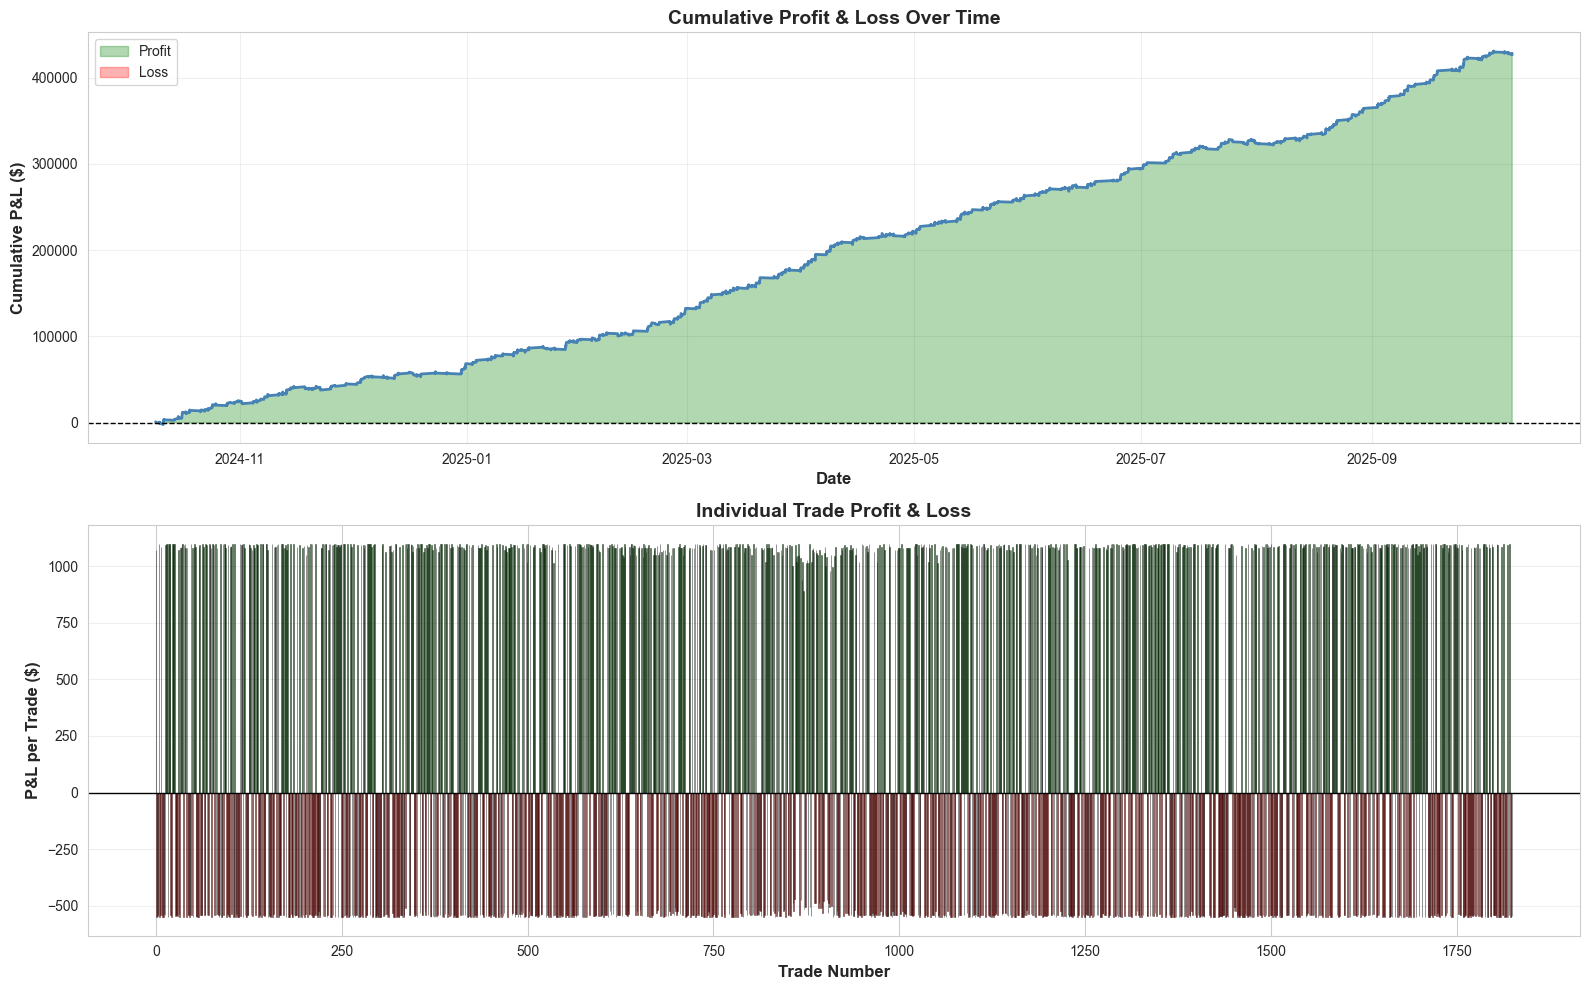


P&L SUMMARY
Total P&L: $426,631.25
Average Win: $1,086.37
Average Loss: $-542.94
Profit Factor: 2.00x
Largest Win: $1,100.00
Largest Loss: $-550.00


In [263]:
# Calculate actual P&L for each trade
df_executed_sorted = df_executed.sort_values('Timestamp_ET').copy()

# For profit trades, use Potential column; for loss trades, use negative At_Risk
df_executed_sorted['PnL'] = df_executed_sorted.apply(
    lambda row: row['Potential'] if row['Status'] == 'Profit' else -row['At_Risk'], 
    axis=1
)

# Calculate cumulative P&L
df_executed_sorted['Cumulative_PnL'] = df_executed_sorted['PnL'].cumsum()

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Cumulative P&L over time
ax1.plot(df_executed_sorted['Timestamp_ET'], df_executed_sorted['Cumulative_PnL'], 
         linewidth=2, color='steelblue')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax1.fill_between(df_executed_sorted['Timestamp_ET'], df_executed_sorted['Cumulative_PnL'], 0,
                  where=df_executed_sorted['Cumulative_PnL'] >= 0, alpha=0.3, color='green', label='Profit')
ax1.fill_between(df_executed_sorted['Timestamp_ET'], df_executed_sorted['Cumulative_PnL'], 0,
                  where=df_executed_sorted['Cumulative_PnL'] < 0, alpha=0.3, color='red', label='Loss')
ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cumulative P&L ($)', fontsize=12, fontweight='bold')
ax1.set_title('Cumulative Profit & Loss Over Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Individual trade P&L
colors_pnl = ['green' if x > 0 else 'red' for x in df_executed_sorted['PnL']]
ax2.bar(range(len(df_executed_sorted)), df_executed_sorted['PnL'], 
        color=colors_pnl, alpha=0.6, edgecolor='black', linewidth=0.5)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('Trade Number', fontsize=12, fontweight='bold')
ax2.set_ylabel('P&L per Trade ($)', fontsize=12, fontweight='bold')
ax2.set_title('Individual Trade Profit & Loss', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary stats
total_pnl = df_executed_sorted['PnL'].sum()
avg_win = df_executed_sorted[df_executed_sorted['Status'] == 'Profit']['PnL'].mean()
avg_loss = df_executed_sorted[df_executed_sorted['Status'] == 'Loss']['PnL'].mean()

print("\nP&L SUMMARY")
print("="*60)
print(f"Total P&L: ${total_pnl:,.2f}")
print(f"Average Win: ${avg_win:,.2f}")
print(f"Average Loss: ${avg_loss:,.2f}")
print(f"Profit Factor: {abs(avg_win / avg_loss):.2f}x" if avg_loss != 0 else "N/A")
print(f"Largest Win: ${df_executed_sorted['PnL'].max():,.2f}")
print(f"Largest Loss: ${df_executed_sorted['PnL'].min():,.2f}")

## 7. Entry Quality: Buying High / Selling Low Analysis

This analysis identifies trades where you went Long near the daily high or Short near the daily low - generally poor entry locations.

In [264]:
############################
# CONFIGURE THRESHOLD HERE #
############################

# Adjust this value to test different thresholds (0.0 to 1.0)
# This represents HOW CLOSE to the extreme you must be to count as "bad"
# 
# 0.1 = Only entries in the EXTREME 10% count as bad (top 10% for Long, bottom 10% for Short)
# 0.2 = Only entries in the EXTREME 20% count as bad (top 20% for Long, bottom 20% for Short)
# 0.3 = Only entries in the EXTREME 30% count as bad
# etc.
#
# SMALLER values = FEWER bad entries (more selective)
# LARGER values = MORE bad entries (less selective)

BAD_ENTRY_THRESHOLD = 0.12

# Calculate the actual thresholds in the 0-1 range
HIGH_THRESHOLD = 1 - BAD_ENTRY_THRESHOLD  # For Long: Must be in top X% of range
LOW_THRESHOLD = BAD_ENTRY_THRESHOLD        # For Short: Must be in bottom X% of range

print("="*80)
print(f"ENTRY QUALITY THRESHOLD: {BAD_ENTRY_THRESHOLD*100:.0f}%")
print("="*80)
print(f"BAD Long Entries: Entry in top {BAD_ENTRY_THRESHOLD*100:.0f}% of daily range (>= {HIGH_THRESHOLD:.2f})")
print(f"BAD Short Entries: Entry in bottom {BAD_ENTRY_THRESHOLD*100:.0f}% of daily range (<= {LOW_THRESHOLD:.2f})")
print("")
print(f"📏 Range Scale: 0.0 = Daily Low, 1.0 = Daily High")
print(f"   Long trades >= {HIGH_THRESHOLD:.2f} are buying near the high (BAD)")
print(f"   Short trades <= {LOW_THRESHOLD:.2f} are selling near the low (BAD)")
print("="*80)

ENTRY QUALITY THRESHOLD: 12%
BAD Long Entries: Entry in top 12% of daily range (>= 0.88)
BAD Short Entries: Entry in bottom 12% of daily range (<= 0.12)

📏 Range Scale: 0.0 = Daily Low, 1.0 = Daily High
   Long trades >= 0.88 are buying near the high (BAD)
   Short trades <= 0.12 are selling near the low (BAD)


In [265]:
# For each day, calculate the daily high and low based on all entry points that day
df_executed['Date'] = df_executed['Timestamp_ET'].dt.date

# Get daily high and low from entry points
daily_extremes = df_executed.groupby('Date')['Entry_Point'].agg(['min', 'max']).reset_index()
daily_extremes.columns = ['Date', 'Daily_Low', 'Daily_High']
daily_extremes['Daily_Range'] = daily_extremes['Daily_High'] - daily_extremes['Daily_Low']

# Merge back to main dataframe
df_with_extremes = df_executed.merge(daily_extremes, on='Date', how='left')

# Calculate where in the daily range each entry occurred (0 = low, 1 = high)
df_with_extremes['Range_Position'] = (
    (df_with_extremes['Entry_Point'] - df_with_extremes['Daily_Low']) / 
    df_with_extremes['Daily_Range']
)

# Define "bad" entries using the configurable threshold
# - Long near high: Range_Position >= HIGH_THRESHOLD (e.g., >= 0.9 for 10% threshold)
# - Short near low: Range_Position <= LOW_THRESHOLD (e.g., <= 0.1 for 10% threshold)

df_with_extremes['Bad_Entry'] = False
df_with_extremes.loc[
    (df_with_extremes['Order_Type'] == 'Long') & (df_with_extremes['Range_Position'] >= HIGH_THRESHOLD),
    'Bad_Entry'
] = True
df_with_extremes.loc[
    (df_with_extremes['Order_Type'] == 'Short') & (df_with_extremes['Range_Position'] <= LOW_THRESHOLD),
    'Bad_Entry'
] = True

# Categorize entries
def categorize_entry(row):
    if row['Order_Type'] == 'Long':
        if row['Range_Position'] >= HIGH_THRESHOLD:
            return 'Long Near High (Bad)'
        elif row['Range_Position'] <= LOW_THRESHOLD:
            return 'Long Near Low (Good)'
        else:
            return 'Long Mid-Range'
    else:  # Short
        if row['Range_Position'] <= LOW_THRESHOLD:
            return 'Short Near Low (Bad)'
        elif row['Range_Position'] >= HIGH_THRESHOLD:
            return 'Short Near High (Good)'
        else:
            return 'Short Mid-Range'

df_with_extremes['Entry_Category'] = df_with_extremes.apply(categorize_entry, axis=1)

print("ENTRY QUALITY ANALYSIS")
print("="*80)
print(f"Total Executed Trades: {len(df_with_extremes)}")
print(f"Bad Entries (Long near high OR Short near low): {df_with_extremes['Bad_Entry'].sum()}")
print(f"Bad Entry Rate: {df_with_extremes['Bad_Entry'].sum() / len(df_with_extremes) * 100:.1f}%")
print(f"\nUsing Threshold: {BAD_ENTRY_THRESHOLD*100:.0f}% from extremes")
print(f"  - Long entries in top {BAD_ENTRY_THRESHOLD*100:.0f}% (Range_Position >= {HIGH_THRESHOLD:.2f}) = BAD")
print(f"  - Short entries in bottom {BAD_ENTRY_THRESHOLD*100:.0f}% (Range_Position <= {LOW_THRESHOLD:.2f}) = BAD")
print("\nBreakdown by Category:")
print(df_with_extremes['Entry_Category'].value_counts().sort_index())

ENTRY QUALITY ANALYSIS
Total Executed Trades: 1825
Bad Entries (Long near high OR Short near low): 258
Bad Entry Rate: 14.1%

Using Threshold: 12% from extremes
  - Long entries in top 12% (Range_Position >= 0.88) = BAD
  - Short entries in bottom 12% (Range_Position <= 0.12) = BAD

Breakdown by Category:
Entry_Category
Long Mid-Range            538
Long Near High (Bad)      143
Long Near Low (Good)      241
Short Mid-Range           534
Short Near High (Good)    254
Short Near Low (Bad)      115
Name: count, dtype: int64


In [266]:
# Win rate analysis by entry quality
entry_quality_stats = df_with_extremes.groupby('Entry_Category').agg({
    'Status': [
        ('Total_Trades', 'count'),
        ('Wins', lambda x: (x == 'Profit').sum()),
        ('Losses', lambda x: (x == 'Loss').sum())
    ]
}).reset_index()

entry_quality_stats.columns = ['Entry_Category', 'Total_Trades', 'Wins', 'Losses']
entry_quality_stats['Win_Rate'] = (entry_quality_stats['Wins'] / entry_quality_stats['Total_Trades'] * 100).round(2)

print("\n" + "="*80)
print("WIN RATE BY ENTRY QUALITY")
print("="*80)
print(entry_quality_stats.to_string(index=False))

# Compare bad entries vs good/mid entries
bad_entries = df_with_extremes[df_with_extremes['Bad_Entry'] == True]
good_entries = df_with_extremes[df_with_extremes['Bad_Entry'] == False]

bad_win_rate = (bad_entries['Status'] == 'Profit').sum() / len(bad_entries) * 100 if len(bad_entries) > 0 else 0
good_win_rate = (good_entries['Status'] == 'Profit').sum() / len(good_entries) * 100 if len(good_entries) > 0 else 0

print("\n" + "="*80)
print("BAD vs GOOD ENTRIES COMPARISON")
print("="*80)
print(f"Bad Entries (Long near high / Short near low):")
print(f"  Count: {len(bad_entries)}")
print(f"  Win Rate: {bad_win_rate:.2f}%")
print(f"  Wins: {(bad_entries['Status'] == 'Profit').sum()}")
print(f"  Losses: {(bad_entries['Status'] == 'Loss').sum()}")

print(f"\nGood/Mid-Range Entries:")
print(f"  Count: {len(good_entries)}")
print(f"  Win Rate: {good_win_rate:.2f}%")
print(f"  Wins: {(good_entries['Status'] == 'Profit').sum()}")
print(f"  Losses: {(good_entries['Status'] == 'Loss').sum()}")

print(f"\nDifference: {good_win_rate - bad_win_rate:.2f} percentage points")
print("="*80)


WIN RATE BY ENTRY QUALITY
        Entry_Category  Total_Trades  Wins  Losses  Win_Rate
        Long Mid-Range           538   224     314     41.64
  Long Near High (Bad)           143    45      98     31.47
  Long Near Low (Good)           241   145      96     60.17
       Short Mid-Range           534   269     265     50.37
Short Near High (Good)           254   146     108     57.48
  Short Near Low (Bad)           115    41      74     35.65

BAD vs GOOD ENTRIES COMPARISON
Bad Entries (Long near high / Short near low):
  Count: 258
  Win Rate: 33.33%
  Wins: 86
  Losses: 172

Good/Mid-Range Entries:
  Count: 1567
  Win Rate: 50.03%
  Wins: 784
  Losses: 783

Difference: 16.70 percentage points


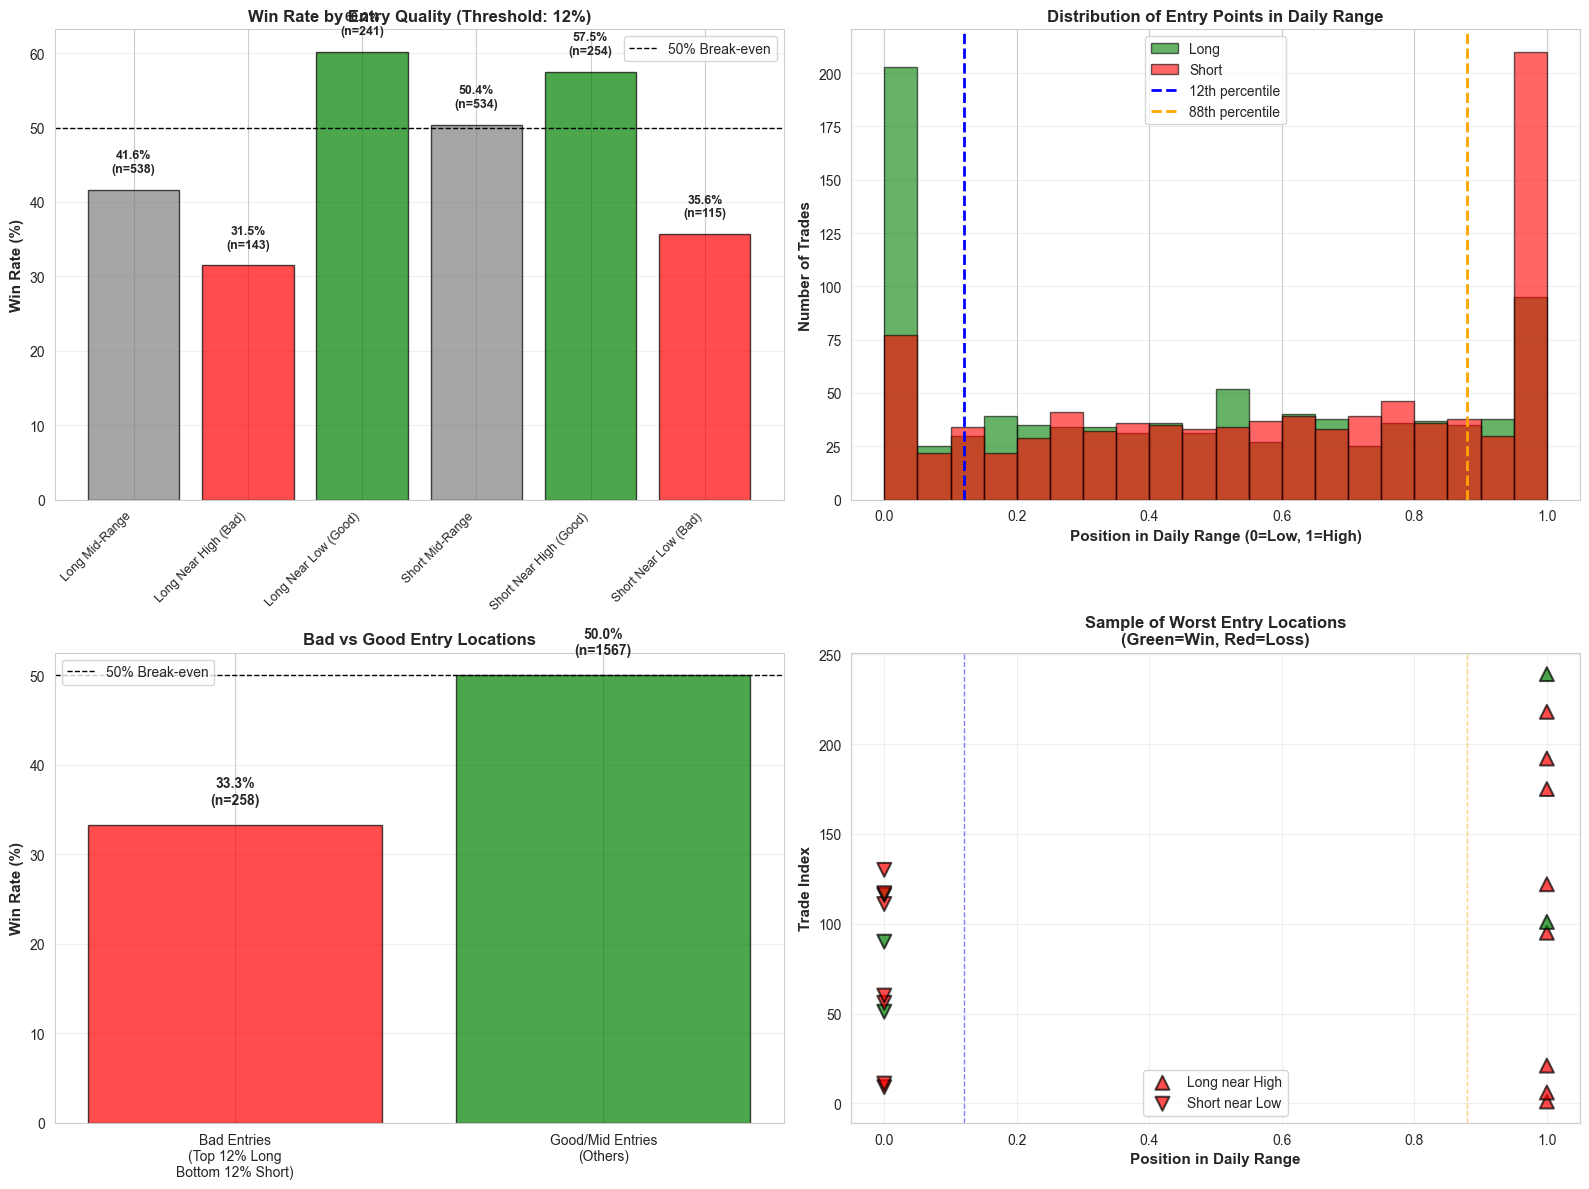

In [267]:
# Visualize entry quality analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Win rate by entry category
ax1 = axes[0, 0]
colors_entry = []
for cat in entry_quality_stats['Entry_Category']:
    if 'Bad' in cat:
        colors_entry.append('red')
    elif 'Good' in cat:
        colors_entry.append('green')
    else:
        colors_entry.append('gray')

bars1 = ax1.bar(range(len(entry_quality_stats)), entry_quality_stats['Win_Rate'], 
                color=colors_entry, alpha=0.7, edgecolor='black')
ax1.axhline(y=50, color='black', linestyle='--', linewidth=1, label='50% Break-even')
ax1.set_xticks(range(len(entry_quality_stats)))
ax1.set_xticklabels(entry_quality_stats['Entry_Category'], rotation=45, ha='right', fontsize=9)
ax1.set_ylabel('Win Rate (%)', fontsize=11, fontweight='bold')
ax1.set_title(f'Win Rate by Entry Quality (Threshold: {BAD_ENTRY_THRESHOLD*100:.0f}%)', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.legend()

for i, (rate, count) in enumerate(zip(entry_quality_stats['Win_Rate'], entry_quality_stats['Total_Trades'])):
    ax1.text(i, rate + 2, f'{rate:.1f}%\n(n={count})', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Distribution of entries across range
ax2 = axes[0, 1]
long_trades = df_with_extremes[df_with_extremes['Order_Type'] == 'Long']
short_trades = df_with_extremes[df_with_extremes['Order_Type'] == 'Short']

ax2.hist(long_trades['Range_Position'], bins=20, alpha=0.6, color='green', label='Long', edgecolor='black')
ax2.hist(short_trades['Range_Position'], bins=20, alpha=0.6, color='red', label='Short', edgecolor='black')
ax2.axvline(x=LOW_THRESHOLD, color='blue', linestyle='--', linewidth=2, label=f'{BAD_ENTRY_THRESHOLD*100:.0f}th percentile')
ax2.axvline(x=HIGH_THRESHOLD, color='orange', linestyle='--', linewidth=2, label=f'{(1-BAD_ENTRY_THRESHOLD)*100:.0f}th percentile')
ax2.set_xlabel('Position in Daily Range (0=Low, 1=High)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Trades', fontsize=11, fontweight='bold')
ax2.set_title('Distribution of Entry Points in Daily Range', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Bad vs Good entries comparison
ax3 = axes[1, 0]
comparison_data = [f'Bad Entries\n(Top {BAD_ENTRY_THRESHOLD*100:.0f}% Long\nBottom {BAD_ENTRY_THRESHOLD*100:.0f}% Short)', 
                   'Good/Mid Entries\n(Others)']
comparison_rates = [bad_win_rate, good_win_rate]
comparison_colors = ['red', 'green']
bars3 = ax3.bar(comparison_data, comparison_rates, color=comparison_colors, alpha=0.7, edgecolor='black')
ax3.axhline(y=50, color='black', linestyle='--', linewidth=1, label='50% Break-even')
ax3.set_ylabel('Win Rate (%)', fontsize=11, fontweight='bold')
ax3.set_title('Bad vs Good Entry Locations', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
ax3.legend()

for bar, rate, count in zip(bars3, [bad_win_rate, good_win_rate], [len(bad_entries), len(good_entries)]):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{rate:.1f}%\n(n={count})', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Sample of worst entries (Long at high / Short at low)
ax4 = axes[1, 1]
worst_longs = df_with_extremes[
    (df_with_extremes['Order_Type'] == 'Long') & 
    (df_with_extremes['Range_Position'] >= HIGH_THRESHOLD)
].nlargest(10, 'Range_Position')

worst_shorts = df_with_extremes[
    (df_with_extremes['Order_Type'] == 'Short') & 
    (df_with_extremes['Range_Position'] <= LOW_THRESHOLD)
].nsmallest(10, 'Range_Position')

if len(worst_longs) > 0:
    ax4.scatter(worst_longs['Range_Position'], worst_longs.index, 
               c=worst_longs['Status'].map({'Profit': 'green', 'Loss': 'red'}),
               marker='^', s=100, alpha=0.7, label='Long near High', edgecolors='black', linewidth=1.5)

if len(worst_shorts) > 0:
    ax4.scatter(worst_shorts['Range_Position'], worst_shorts.index,
               c=worst_shorts['Status'].map({'Profit': 'green', 'Loss': 'red'}),
               marker='v', s=100, alpha=0.7, label='Short near Low', edgecolors='black', linewidth=1.5)

ax4.axvline(x=LOW_THRESHOLD, color='blue', linestyle='--', linewidth=1, alpha=0.5)
ax4.axvline(x=HIGH_THRESHOLD, color='orange', linestyle='--', linewidth=1, alpha=0.5)
ax4.set_xlabel('Position in Daily Range', fontsize=11, fontweight='bold')
ax4.set_ylabel('Trade Index', fontsize=11, fontweight='bold')
ax4.set_title('Sample of Worst Entry Locations\n(Green=Win, Red=Loss)', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [268]:
# Detailed breakdown: How often do you enter at bad locations?
print("\n" + "="*80)
print("DETAILED BREAKDOWN: BAD ENTRY FREQUENCY")
print("="*80)

# Frequency by order type
long_total = len(df_with_extremes[df_with_extremes['Order_Type'] == 'Long'])
long_bad = len(df_with_extremes[(df_with_extremes['Order_Type'] == 'Long') & (df_with_extremes['Range_Position'] >= HIGH_THRESHOLD)])

short_total = len(df_with_extremes[df_with_extremes['Order_Type'] == 'Short'])
short_bad = len(df_with_extremes[(df_with_extremes['Order_Type'] == 'Short') & (df_with_extremes['Range_Position'] <= LOW_THRESHOLD)])

print(f"\nLong Trades:")
print(f"  Total: {long_total}")
print(f"  Entered in top {BAD_ENTRY_THRESHOLD*100:.0f}% of range (>= {HIGH_THRESHOLD:.2f}) [BAD]: {long_bad} ({long_bad/long_total*100:.1f}%)")
print(f"  Win rate when entering top {BAD_ENTRY_THRESHOLD*100:.0f}%: {(df_with_extremes[(df_with_extremes['Order_Type'] == 'Long') & (df_with_extremes['Range_Position'] >= HIGH_THRESHOLD) & (df_with_extremes['Status'] == 'Profit')].shape[0] / long_bad * 100):.1f}%" if long_bad > 0 else f"  Win rate when entering top {BAD_ENTRY_THRESHOLD*100:.0f}%: N/A")

print(f"\nShort Trades:")
print(f"  Total: {short_total}")
print(f"  Entered in bottom {BAD_ENTRY_THRESHOLD*100:.0f}% of range (<= {LOW_THRESHOLD:.2f}) [BAD]: {short_bad} ({short_bad/short_total*100:.1f}%)")
print(f"  Win rate when entering bottom {BAD_ENTRY_THRESHOLD*100:.0f}%: {(df_with_extremes[(df_with_extremes['Order_Type'] == 'Short') & (df_with_extremes['Range_Position'] <= LOW_THRESHOLD) & (df_with_extremes['Status'] == 'Profit')].shape[0] / short_bad * 100):.1f}%" if short_bad > 0 else f"  Win rate when entering bottom {BAD_ENTRY_THRESHOLD*100:.0f}%: N/A")

print("\n" + "="*80)
print("KEY INSIGHT:")
if bad_win_rate < good_win_rate:
    diff = good_win_rate - bad_win_rate
    print(f"❌ Bad entries reduce your win rate by {diff:.1f} percentage points!")
    print(f"   If you could avoid these {len(bad_entries)} bad entries, your overall")
    print(f"   win rate would improve from {(df_with_extremes['Status'] == 'Profit').sum() / len(df_with_extremes) * 100:.1f}% to approximately {good_win_rate:.1f}%")
elif bad_win_rate > good_win_rate:
    print(f"🤔 Interestingly, your 'bad' entries actually have a HIGHER win rate.")
    print(f"   This suggests either:")
    print(f"   1. Your strategy works well with reversal plays, or")
    print(f"   2. The daily range calculation needs refinement")
else:
    print(f"Entry location doesn't seem to matter much for your strategy.")
print("="*80)


DETAILED BREAKDOWN: BAD ENTRY FREQUENCY

Long Trades:
  Total: 922
  Entered in top 12% of range (>= 0.88) [BAD]: 143 (15.5%)
  Win rate when entering top 12%: 31.5%

Short Trades:
  Total: 903
  Entered in bottom 12% of range (<= 0.12) [BAD]: 115 (12.7%)
  Win rate when entering bottom 12%: 35.7%

KEY INSIGHT:
❌ Bad entries reduce your win rate by 16.7 percentage points!
   If you could avoid these 258 bad entries, your overall
   win rate would improve from 47.7% to approximately 50.0%


## 8. Actionable Rules: Entry Quality Filter

Based on the analysis above, here are specific rules you could implement:

In [269]:
# What-if analysis: What if you avoided bad entries? (DOLLAR IMPACT)
print("\n" + "="*80)
print("WHAT-IF ANALYSIS: AVOIDING BAD ENTRIES - DOLLAR IMPACT")
print("="*80)

total_trades = len(df_with_extremes)
current_wins = (df_with_extremes['Status'] == 'Profit').sum()
current_losses = (df_with_extremes['Status'] == 'Loss').sum()
current_win_rate = current_wins / total_trades * 100

# If we removed bad entries entirely
remaining_trades = len(good_entries)
projected_wins = (good_entries['Status'] == 'Profit').sum()
projected_losses = (good_entries['Status'] == 'Loss').sum()
projected_win_rate = projected_wins / remaining_trades * 100 if remaining_trades > 0 else 0

# Breakdown of what we're removing
bad_wins = (bad_entries['Status'] == 'Profit').sum()
bad_losses = (bad_entries['Status'] == 'Loss').sum()
bad_win_rate = bad_wins / len(bad_entries) * 100 if len(bad_entries) > 0 else 0

print(f"\n📊 CURRENT PERFORMANCE:")
print(f"  Total trades: {total_trades}")
print(f"  Wins: {current_wins} | Losses: {current_losses}")
print(f"  Win rate: {current_win_rate:.1f}%")

print(f"\n🎯 PROJECTED PERFORMANCE (avoiding bad entries):")
print(f"  Remaining trades: {remaining_trades} (removed {len(bad_entries)} bad entries)")
print(f"  Projected wins: {projected_wins} | Projected losses: {projected_losses}")
print(f"  Projected win rate: {projected_win_rate:.1f}%")
print(f"  Improvement: {projected_win_rate - current_win_rate:+.1f} percentage points")

print(f"\n❌ WHAT WE'RE REMOVING:")
print(f"  Bad entries: {len(bad_entries)} trades")
print(f"  Losing {bad_wins} winners (sacrificing some good trades)")
print(f"  Losing {bad_losses} losers (avoiding bad trades)")
print(f"  Bad entry win rate: {bad_win_rate:.1f}%")

# Calculate the dollar impact using actual average win/loss from P&L summary
print(f"\n💰 DOLLAR IMPACT ANALYSIS:")

# Use actual values from your trading data
avg_win = 1086.37  # Average win per winning trade
avg_loss = 542.94  # Average loss per losing trade (absolute value)
risk_reward_ratio = avg_win / avg_loss

print(f"  Average Win: ${avg_win:,.2f}")
print(f"  Average Loss: ${avg_loss:,.2f}")
print(f"  Risk:Reward Ratio: 1:{risk_reward_ratio:.2f}")

# Calculate P&L
current_pnl = (current_wins * avg_win) - (current_losses * avg_loss)
projected_pnl = (projected_wins * avg_win) - (projected_losses * avg_loss)
bad_entries_pnl = (bad_wins * avg_win) - (bad_losses * avg_loss)

print(f"\n  Current P&L (estimated): ${current_pnl:,.2f}")
print(f"  Projected P&L (without bad entries): ${projected_pnl:,.2f}")
print(f"  P&L from bad entries alone: ${bad_entries_pnl:,.2f}")
print(f"  Net improvement: ${projected_pnl - current_pnl:+,.2f}")

# Show the trade-off clearly
winners_given_up = bad_wins * avg_win
losers_avoided = bad_losses * avg_loss
net_benefit = losers_avoided - winners_given_up

print(f"\n  🔍 TRADE-OFF BREAKDOWN:")
print(f"     Giving up {bad_wins} winners × ${avg_win:,.2f} = -${winners_given_up:,.2f}")
print(f"     Avoiding {bad_losses} losers × ${avg_loss:,.2f} = +${losers_avoided:,.2f}")
print(f"     Net benefit: ${net_benefit:+,.2f}")

if net_benefit > 0:
    print(f"\n  ✅ VERDICT: Avoiding bad entries PAYS OFF!")
    print(f"     Even with your 1:{risk_reward_ratio:.2f} risk:reward ratio, you avoid ${losers_avoided:,.2f}")
    print(f"     in losses while only giving up ${winners_given_up:,.2f} in wins.")
    print(f"     Net gain: ${net_benefit:,.2f}")
elif net_benefit < 0:
    print(f"\n  ⚠️  VERDICT: The trade-off is NEGATIVE.")
    print(f"     Your 1:{risk_reward_ratio:.2f} risk:reward ratio means the {bad_wins} winners you'd give up")
    print(f"     (${winners_given_up:,.2f}) are worth more than the {bad_losses} losers you'd avoid (${losers_avoided:,.2f}).")
    print(f"     Net loss: ${abs(net_benefit):,.2f}")
else:
    print(f"\n  ⚖️  VERDICT: The trade-off is neutral.")

print("\n" + "="*80)
print(f"💡 RECOMMENDATION:")
print(f"   Consider implementing a filter to avoid entering Long positions in the")
print(f"   top {BAD_ENTRY_THRESHOLD*100:.0f}% of the daily range, and Short positions in the bottom {BAD_ENTRY_THRESHOLD*100:.0f}%.")
if net_benefit > 0:
    print(f"   This could improve your P&L by approximately ${net_benefit:,.2f}")
    improvement_pct = (net_benefit / abs(current_pnl) * 100) if current_pnl != 0 else 0
    print(f"   That's a {improvement_pct:.1f}% improvement in total P&L!")
print("="*80)


WHAT-IF ANALYSIS: AVOIDING BAD ENTRIES - DOLLAR IMPACT

📊 CURRENT PERFORMANCE:
  Total trades: 1825
  Wins: 870 | Losses: 955
  Win rate: 47.7%

🎯 PROJECTED PERFORMANCE (avoiding bad entries):
  Remaining trades: 1567 (removed 258 bad entries)
  Projected wins: 784 | Projected losses: 783
  Projected win rate: 50.0%
  Improvement: +2.4 percentage points

❌ WHAT WE'RE REMOVING:
  Bad entries: 258 trades
  Losing 86 winners (sacrificing some good trades)
  Losing 172 losers (avoiding bad trades)
  Bad entry win rate: 33.3%

💰 DOLLAR IMPACT ANALYSIS:
  Average Win: $1,086.37
  Average Loss: $542.94
  Risk:Reward Ratio: 1:2.00

  Current P&L (estimated): $426,634.20
  Projected P&L (without bad entries): $426,592.06
  P&L from bad entries alone: $42.14
  Net improvement: $-42.14

  🔍 TRADE-OFF BREAKDOWN:
     Giving up 86 winners × $1,086.37 = -$93,427.82
     Avoiding 172 losers × $542.94 = +$93,385.68
     Net benefit: $-42.14

  ⚠️  VERDICT: The trade-off is NEGATIVE.
     Your 1:2.00 


THRESHOLD OPTIMIZATION ANALYSIS
Testing thresholds from 0% to 30% to find optimal filtering level...


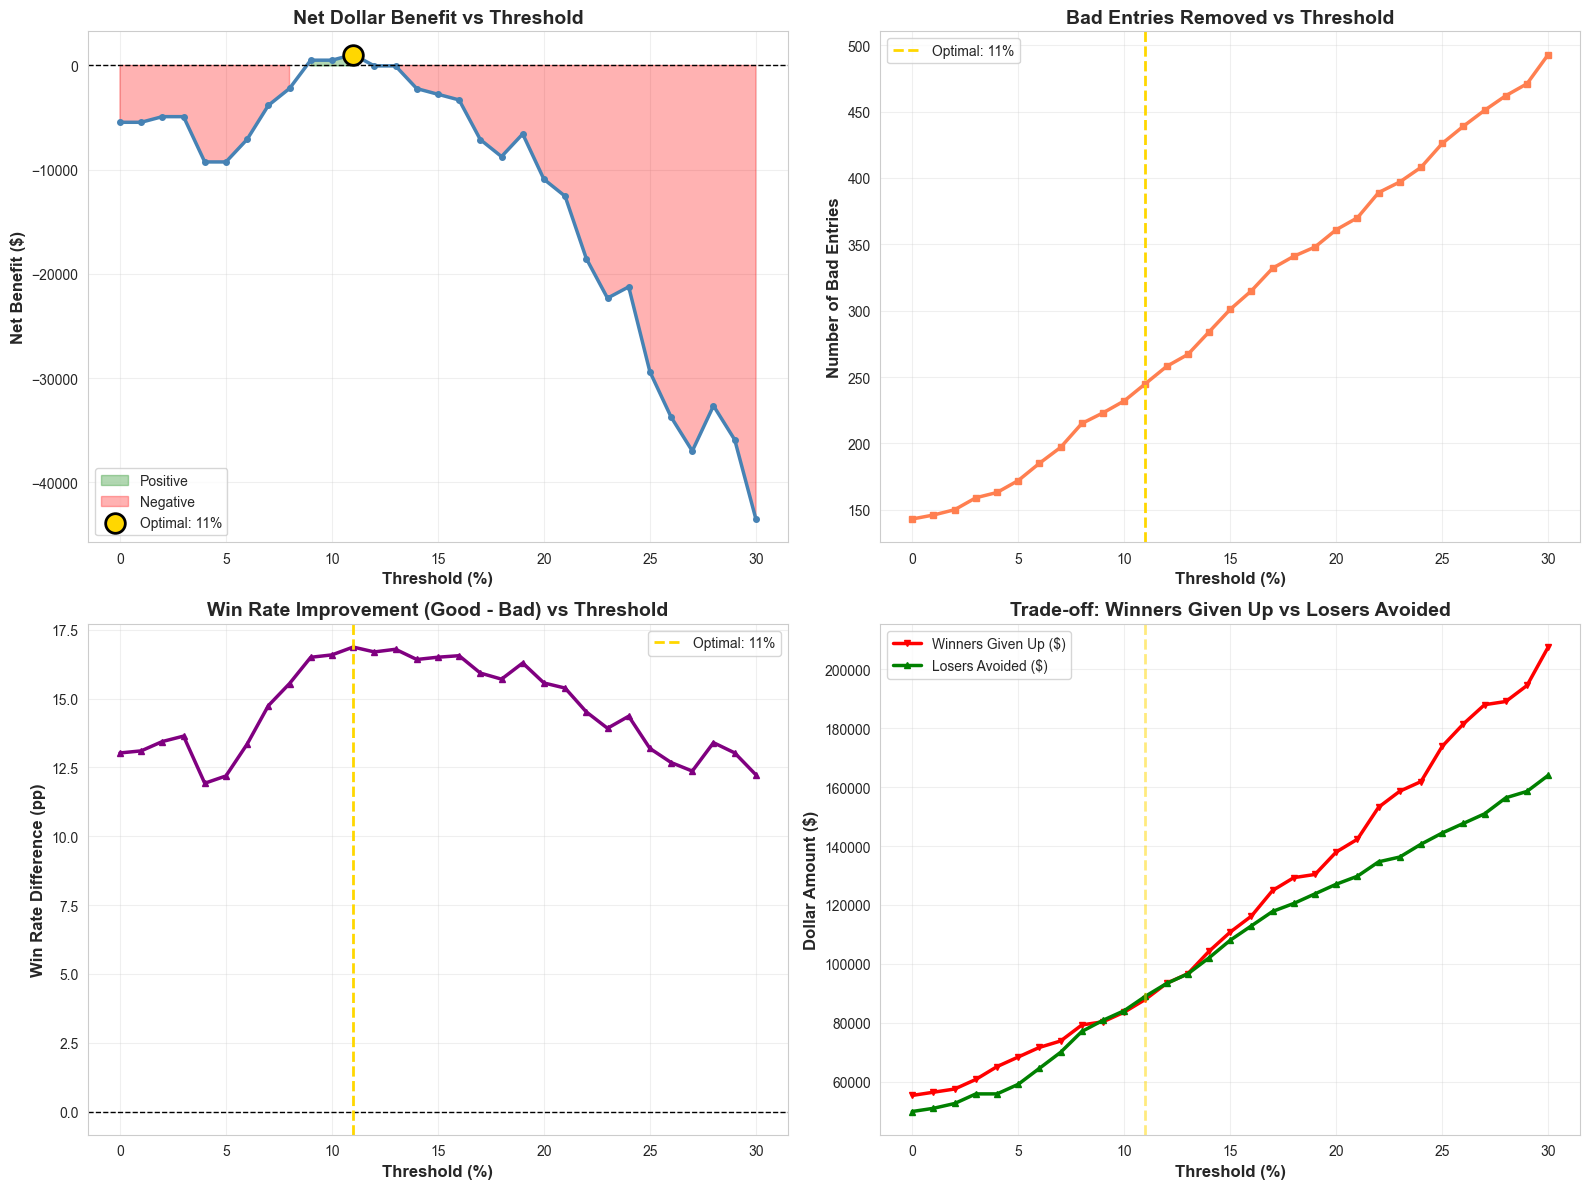


🎯 OPTIMAL THRESHOLD FOUND: 11%
At 11% threshold:
  Bad entries removed: 245
  Winners given up: 81
  Losers avoided: 164
  Net benefit: $1,046.19
  Bad entry win rate: 33.1%
  Good entry win rate: 49.9%
  Win rate difference: 16.9 pp

📊 TOP 5 THRESHOLDS BY NET BENEFIT:
 Threshold (%)  Bad Entries  Net Benefit ($)  Win Rate Diff (pp)
          11.0          245          1046.19           16.875484
           9.0          223           506.68           16.504034
          10.0          232           505.21           16.590634
          12.0          258           -42.14           16.698575
          13.0          267           -43.61           16.795036


In [270]:
# Threshold Optimization: Test different thresholds to find the sweet spot
print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION ANALYSIS")
print("="*80)
print("Testing thresholds from 0% to 30% to find optimal filtering level...")
print("="*80)

# Test thresholds from 0% to 30% in 1% increments
thresholds = np.arange(0, 0.31, 0.01)
results = []

avg_win = 1086.37
avg_loss = 542.94

for threshold in thresholds:
    high_thresh = 1 - threshold
    low_thresh = threshold
    
    # Identify bad entries for this threshold
    bad_mask = (
        ((df_with_extremes['Order_Type'] == 'Long') & (df_with_extremes['Range_Position'] >= high_thresh)) |
        ((df_with_extremes['Order_Type'] == 'Short') & (df_with_extremes['Range_Position'] <= low_thresh))
    )
    
    bad_entries_test = df_with_extremes[bad_mask]
    good_entries_test = df_with_extremes[~bad_mask]
    
    # Calculate metrics
    num_bad = len(bad_entries_test)
    bad_wins_test = (bad_entries_test['Status'] == 'Profit').sum()
    bad_losses_test = (bad_entries_test['Status'] == 'Loss').sum()
    
    # Calculate dollar impact
    winners_given_up = bad_wins_test * avg_win
    losers_avoided = bad_losses_test * avg_loss
    net_benefit = losers_avoided - winners_given_up
    
    # Calculate win rates
    bad_win_rate_test = (bad_wins_test / num_bad * 100) if num_bad > 0 else 0
    good_win_rate_test = ((good_entries_test['Status'] == 'Profit').sum() / len(good_entries_test) * 100) if len(good_entries_test) > 0 else 0
    
    results.append({
        'threshold': threshold * 100,
        'num_bad_entries': num_bad,
        'bad_wins': bad_wins_test,
        'bad_losses': bad_losses_test,
        'net_benefit': net_benefit,
        'bad_win_rate': bad_win_rate_test,
        'good_win_rate': good_win_rate_test,
        'win_rate_diff': good_win_rate_test - bad_win_rate_test
    })

results_df = pd.DataFrame(results)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Net Benefit by Threshold
ax1 = axes[0, 0]
ax1.plot(results_df['threshold'], results_df['net_benefit'], linewidth=2.5, color='steelblue', marker='o', markersize=4)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax1.fill_between(results_df['threshold'], results_df['net_benefit'], 0, 
                  where=results_df['net_benefit'] >= 0, alpha=0.3, color='green', label='Positive')
ax1.fill_between(results_df['threshold'], results_df['net_benefit'], 0, 
                  where=results_df['net_benefit'] < 0, alpha=0.3, color='red', label='Negative')
ax1.set_xlabel('Threshold (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Net Benefit ($)', fontsize=12, fontweight='bold')
ax1.set_title('Net Dollar Benefit vs Threshold', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Mark the optimal threshold
max_benefit_idx = results_df['net_benefit'].idxmax()
optimal_threshold = results_df.loc[max_benefit_idx, 'threshold']
optimal_benefit = results_df.loc[max_benefit_idx, 'net_benefit']
ax1.scatter([optimal_threshold], [optimal_benefit], color='gold', s=200, zorder=5, 
           edgecolors='black', linewidth=2, label=f'Optimal: {optimal_threshold:.0f}%')
ax1.legend()

# 2. Number of Bad Entries by Threshold
ax2 = axes[0, 1]
ax2.plot(results_df['threshold'], results_df['num_bad_entries'], linewidth=2.5, color='coral', marker='s', markersize=4)
ax2.set_xlabel('Threshold (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Bad Entries', fontsize=12, fontweight='bold')
ax2.set_title('Bad Entries Removed vs Threshold', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=optimal_threshold, color='gold', linestyle='--', linewidth=2, label=f'Optimal: {optimal_threshold:.0f}%')
ax2.legend()

# 3. Win Rate Difference
ax3 = axes[1, 0]
ax3.plot(results_df['threshold'], results_df['win_rate_diff'], linewidth=2.5, color='purple', marker='^', markersize=4)
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.set_xlabel('Threshold (%)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Win Rate Difference (pp)', fontsize=12, fontweight='bold')
ax3.set_title('Win Rate Improvement (Good - Bad) vs Threshold', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.axvline(x=optimal_threshold, color='gold', linestyle='--', linewidth=2, label=f'Optimal: {optimal_threshold:.0f}%')
ax3.legend()

# 4. Trade-off: Winners Given Up vs Losers Avoided
ax4 = axes[1, 1]
winners_given = results_df['bad_wins'] * avg_win
losers_avoided_vals = results_df['bad_losses'] * avg_loss
ax4.plot(results_df['threshold'], winners_given, linewidth=2.5, color='red', marker='v', markersize=4, label='Winners Given Up ($)')
ax4.plot(results_df['threshold'], losers_avoided_vals, linewidth=2.5, color='green', marker='^', markersize=4, label='Losers Avoided ($)')
ax4.set_xlabel('Threshold (%)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Dollar Amount ($)', fontsize=12, fontweight='bold')
ax4.set_title('Trade-off: Winners Given Up vs Losers Avoided', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend()
ax4.axvline(x=optimal_threshold, color='gold', linestyle='--', linewidth=2, alpha=0.5)

plt.tight_layout()
plt.show()

# Print summary
print(f"\n🎯 OPTIMAL THRESHOLD FOUND: {optimal_threshold:.0f}%")
print("="*80)
print(f"At {optimal_threshold:.0f}% threshold:")
print(f"  Bad entries removed: {results_df.loc[max_benefit_idx, 'num_bad_entries']:.0f}")
print(f"  Winners given up: {results_df.loc[max_benefit_idx, 'bad_wins']:.0f}")
print(f"  Losers avoided: {results_df.loc[max_benefit_idx, 'bad_losses']:.0f}")
print(f"  Net benefit: ${optimal_benefit:,.2f}")
print(f"  Bad entry win rate: {results_df.loc[max_benefit_idx, 'bad_win_rate']:.1f}%")
print(f"  Good entry win rate: {results_df.loc[max_benefit_idx, 'good_win_rate']:.1f}%")
print(f"  Win rate difference: {results_df.loc[max_benefit_idx, 'win_rate_diff']:.1f} pp")
print("="*80)

# Show top 5 thresholds by net benefit
print("\n📊 TOP 5 THRESHOLDS BY NET BENEFIT:")
print("="*80)
top_5 = results_df.nlargest(5, 'net_benefit')[['threshold', 'num_bad_entries', 'net_benefit', 'win_rate_diff']]
top_5.columns = ['Threshold (%)', 'Bad Entries', 'Net Benefit ($)', 'Win Rate Diff (pp)']
print(top_5.to_string(index=False))
print("="*80)